<a href="https://colab.research.google.com/github/mvfolino68/CFPB_complaints_notebook/blob/master/CFPB_Text_Topic_Extraction_Spacyv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CFPB Text Analytics

![alt text](https://www.consumerfinance.gov/static/img/logo_237x50.c7c2ba6c929f.png)

---


#Our Problem - Identify Common Topics in Customer Complaints to Consumer Financial Protection Bureau


---


#Our Solution - Use Natural Language Processing to Extract Repeated Topics and Rank Sentiments

---




##Import Modules

In [0]:
#@title
!pip install pyLDAvis
# Usual imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os


# Plotly based imports for visualization
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg

##Import the Data

In [0]:
#@title
df = pd.read_csv('https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD', encoding='utf-8')
df.head()

##Pre Process and Explore the Data

###Function creation for preprocessing

In [0]:
#@title
# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')
#create word lemmetizer object, stopwords
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):

    mytokens = [char for char in sentence if char not in ['X']]
    

    # Join the characters again to form the string.
    mytokens = ''.join(mytokens)
    mytokens = parser(mytokens)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations and word.isalpha()]
    mytokens = " ".join([i for i in mytokens]).replace(' m t ', ' ')  
    return mytokens

###Pre Processing data

In [0]:
#@title
tqdm.pandas()
bank_name = 'M&T BANK CORPORATION'
df = df[pd.notnull(df['Consumer complaint narrative'].str.strip())]
df =df[df['Company'].str.contains(bank_name)]
#clean cols
df['Consumer complaint narrative clean'] = df['Consumer complaint narrative'].apply(spacy_tokenizer)

In [0]:
#@title
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace = True)

###Check the cleaned text

In [0]:
#@title
df.head()

In [0]:
print(df.shape)
print(df.columns)

(741, 19)
Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID',
       'Consumer complaint narrative clean'],
      dtype='object')


#Explore the Summary Stats by Year and Feature

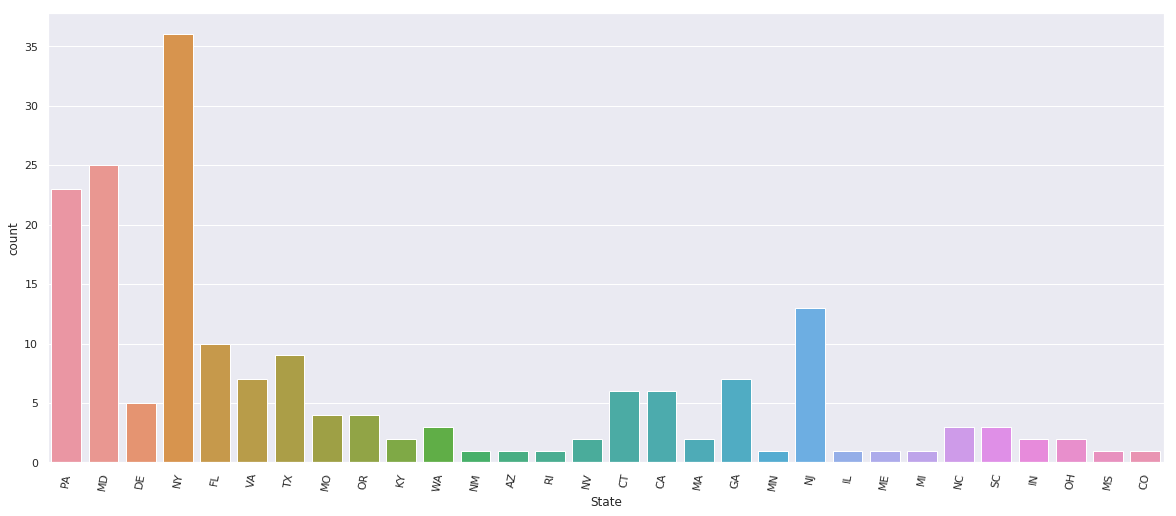

In [0]:
#@title Adjust Year and Feature to Measure { run: "auto" }
sns.set(rc={'figure.figsize':(20,8.27)})
Year = 2017 #@param {type:"slider", min:2015, max:2019, step:1}
Select_Variable = "State" #@param ["Product", "Sub-product", "Issue", "State", "Company response to consumer", "Timely response?"]

g = sns.countplot(x = Select_Variable, data = df[df['Date received'].str.contains(str(Year))])
for item in g.get_xticklabels():
    item.set_rotation(80)

# Analysis

###define function to view topics

In [0]:
#@title
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

#Review results of 3 different approaches to topic extraction

In [0]:
#@title View Top 10 phrases for 10 topics{ run: "auto" }

Year = 2017 #@param {type:"slider", min:2015, max:2019, step:1}
Select_Product = "Mortgage" #@param ['Mortgage', 'Checking or savings account','Money transfer, virtual currency, or money service','Debt collection','Credit reporting, credit repair services, or other personal consumer reports','Credit card or prepaid card', 'Vehicle loan or lease','Payday loan, title loan, or personal loan', 'Consumer Loan','Bank account or service', 'Credit card', 'Credit reporting']
Topic_Model_Select = nmf #@param ["lda", "nmf", "lsi"] {type:"raw"}
try:
    #define function for vectorizer and topic models
    # Creating a vectorizer
    vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True#, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'
                               , ngram_range=(1,3))
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True#, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'
                                     , ngram_range=(1,3))
    #vectorize
    data_vectorized_tfidf = tfidf_vectorizer.fit_transform(df[(df['Date received'].str.contains(str(Year))) & (df['Product']==Select_Product)]['Consumer complaint narrative clean'])
    data_vectorized = vectorizer.fit_transform(df[(df['Date received'].str.contains(str(Year))) & (df['Product']==Select_Product)]['Consumer complaint narrative clean'])
    #define our 3 topic models
    NUM_TOPICS = 10
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=False)
    data_lda = lda.fit_transform(data_vectorized_tfidf)

    # Non-Negative Matrix Factorization Model
    nmf = NMF(n_components=NUM_TOPICS, alpha=.1, l1_ratio=.5)
    data_nmf = nmf.fit_transform(data_vectorized_tfidf) 

    # Latent Semantic Indexing Model using Truncated SVD
    lsi = TruncatedSVD(n_components=NUM_TOPICS)
    data_lsi = lsi.fit_transform(data_vectorized_tfidf)
    
    # Keywords for topics clustered by Latent Dirichlet Allocation
    print(f"Model:{Topic_Model_Select} ")
    print('_'*100)
    selected_topics(Topic_Model_Select, tfidf_vectorizer)
    print('_'*100)
except:
    print("Oops!  Not Enough Data, Select a Different Year or Product")





Model:NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
  n_components=10, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0) 
____________________________________________________________________________________________________
Topic 0:
['bank', 'loan', 'modification', 'court', 'loan modification', 'case', 'original', 'date', 'transfer', 'law']
Topic 1:
['payment', 'bank', 'late', 'mortgage', 'month', 'tell', 'late payment', 'check', 'want', 'mortgage payment']
Topic 2:
['income', 'deny', 'apply', 'base', 'modification', 'mortgage', 'fha', 'fall', 'guideline', 'tell']
Topic 3:
['bank', 'close', 'escrow', 'letter', 'send', 'fax', 'taxis', 'good', 'loan', 'address']
Topic 4:
['property', 'foreclosure', 'pay', 'sale', 'foreclosure bank', 'bank', 'sell', 'request', 'balance', 'foreclose']
Topic 5:
['request', 'qualify', 'write', 'write request', 'lender', 'information', 'sale date', 'review', 'date', 'submit']
Topic 6:
['credit', 'account', '

#Hide

##create function and apply to data

In [0]:
#@title
from textblob import TextBlob 

#define sentiment function using textblob

def get_sentiment(text): 
    ''' 
    Utility function to classify sentiment of passed text 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(text) 
    return analysis.sentiment.polarity 
    # set sentiment 
#     if analysis.sentiment.polarity > 0: 
#         return 'positive'
#     elif analysis.sentiment.polarity == 0: 
#         return 'neutral'
#     else: 
#         return 'negative'

#apply sentinment
df['sentiment'] = df['Consumer complaint narrative clean'].apply(get_sentiment)


#df.to_csv('CFPB_output.csv')

df.head(500)

#Sentiment Distribution, -1 is lowest negative, 0 is neutral, 1 is highest positive

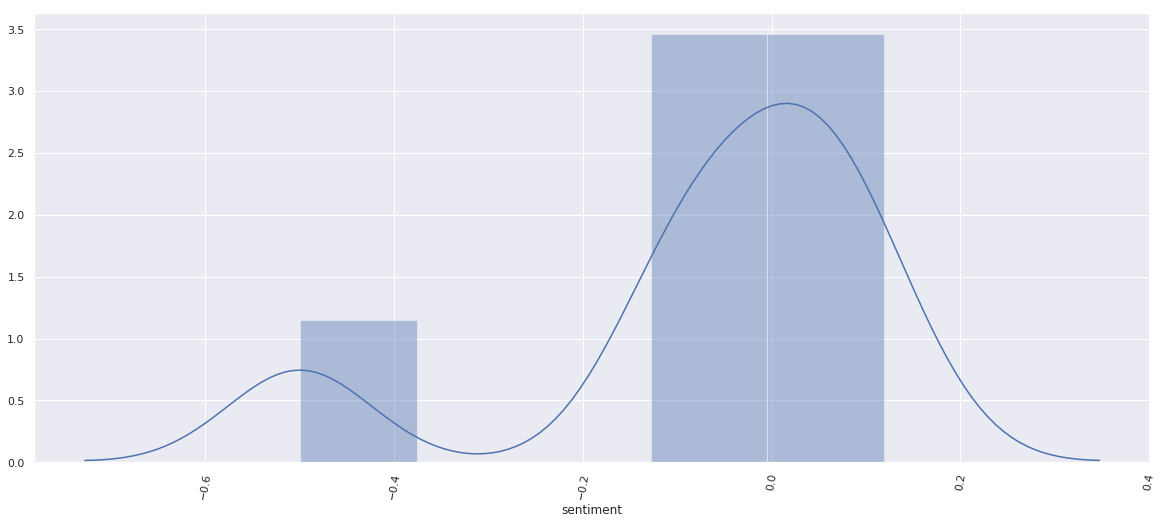

In [0]:
#@title View Sentiment Score by Product and Year { run: "auto" }
sns.set(rc={'figure.figsize':(20,8.27)})
Year = 2019 #@param {type:"slider", min:2015, max:2019, step:1}
Select_Product = "Checking or savings account" #@param ['Mortgage', 'Checking or savings account','Money transfer, virtual currency, or money service','Debt collection','Credit reporting, credit repair services, or other personal consumer reports','Credit card or prepaid card', 'Vehicle loan or lease','Payday loan, title loan, or personal loan', 'Consumer Loan','Bank account or service', 'Credit card', 'Credit reporting']

g = sns.distplot(df[(df['Date received'].str.contains(str(Year))) & (df['Product']==Select_Product)].sentiment)
for item in g.get_xticklabels():
    item.set_rotation(80)